# TP Data Science - Apprentissage Surpevisé


## Etude du jeu de données "Mushroom"

In [1]:
# Import des librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import graphviz
plt.ion()

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score

import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
plt.style.use('seaborn-darkgrid')

## Données

In [2]:
# Import
df_mushrooms = pd.read_csv('data/df_mushrooms.csv', delimiter = ';')
print("Nombre de colonnes :", len(df_mushrooms.columns))
print("Nombre de lignes :", len(df_mushrooms.values))
df_mushrooms

Nombre de colonnes : 23
Nombre de lignes : 8124


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [3]:
# Séparation des observations et classe
X = df_mushrooms.drop('class', axis = 1)
y = df_mushrooms['class']

# Codage des classes : edible = 0, poisonous = 1 
print("Classes étudiées :", pd.unique(y))
y = y.replace('e', 0)
y = y.replace('p', 1)

df_mushrooms['class'].value_counts()

Classes étudiées : ['p' 'e']


e    4208
p    3916
Name: class, dtype: int64

In [4]:
print("Valeurs possibles pour chaque feature :")
for x in X:
    print("{} : {}".format(x, pd.unique(X[x])))

Valeurs possibles pour chaque feature :
cap-shape : ['x' 'b' 's' 'f' 'k' 'c']
cap-surface : ['s' 'y' 'f' 'g']
cap-color : ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises : ['t' 'f']
odor : ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment : ['f' 'a']
gill-spacing : ['c' 'w']
gill-size : ['n' 'b']
gill-color : ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape : ['e' 't']
stalk-root : ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring : ['s' 'f' 'k' 'y']
stalk-surface-below-ring : ['s' 'f' 'y' 'k']
stalk-color-above-ring : ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring : ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type : ['p']
veil-color : ['w' 'n' 'o' 'y']
ring-number : ['o' 't' 'n']
ring-type : ['p' 'e' 'l' 'f' 'n']
spore-print-color : ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population : ['s' 'n' 'a' 'v' 'y' 'c']
habitat : ['u' 'g' 'm' 'd' 'p' 'w' 'l']


La colonne *veil-type* est constante. On peut la retirer car elle n'ajoute aucune information et risque d'influencer négativement nos modèles.

In [5]:
X = X.drop('veil-type', axis = 1)

## Encodage des données quantitatives<br>

Pour pouvoir manipuler les données, il est nécessaire de transformer les données quantitatives en données qualitatives. Pour cela, on encode les observations selon cette logique :

1. On regarde le nombre de valeurs pouvant être prise par chaque feature.
2. On considère chaque feature comme un vecteur de cette taille.
3. Une observation sera un vecteur dont la composante associée vaudra 1 et les autres 0.

> Exemple : feature *cap-surface*
> 1. Cette feature a 4 valeurs possibles : [s, y, f, g]
> 2. Le vecteur de cette feature est de taille 4
> 3. L'observation 's' sera codée : [1, 0, 0, 0]

Une fonction fournie par la librairie pandas permet de résumer toute cette logique en une seule opération, et éclate chaque vecteur en plusieurs colonnes :

In [6]:
X_qual = pd.get_dummies(X, prefix_sep='_')
X_qual.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


## Sélection des features

Notre modélisation a fortement augmenté le nombre de features. Afin d'assurer la fiabilité de notre analyse, il est nécessaire de sélectionner les features les plus importantes. Ceci aura pour effet de généraliser notre analyse et de réduire le sur-apprentissage. Dans le TP précédent, nous avions réalisé une sélection manuelle selon les histogrammes des valeurs, suivie d'une analyse de la multi-colinéarité + VIF. Ici, nous nous intéresserons à une méthode très populaire en machine learning : les Random Forest. 

### Sélection par Random Forest

De fait de leur construction, les Random Forest permettent de bonnes prédictions en limitant le sur-apprentissage. De plus, ils permettent de faire remonter les features importantes : les features se trouvant dans la partie supérieure des arbres fournissent beaucoup d'informations car elles séparent la décision en deux, ce qui est par définition signe d'une feature a priori très pertinente.

> **Méthode :**
> 1. Entrainer le modèle Random Forest sur les données d'entrainement
> 2. Récupérer le taux d'importance chaque feature dans les Decision Tree.
> 3. Conserver les features selon un certain seuil d'importance.
> 4. Si le seuil est trop bas, la sélection ne sera pas assez discriminante. On peut le choisir empyriquement en s'appuyant sur la performance des modèles utilisés plus tard dans ce notebook.

5443 données d'apprentissage
2681 données de test


<AxesSubplot:>

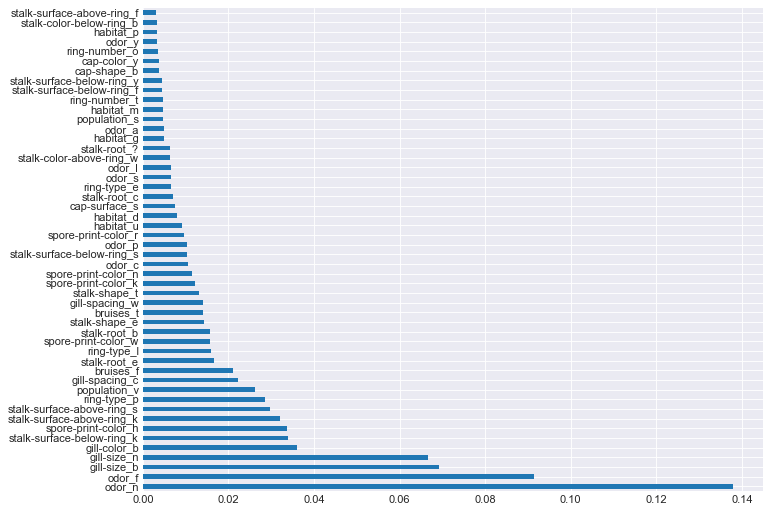

In [10]:
# Normalisation des données :
X_norm = StandardScaler().fit_transform(X_qual)

# Séparation entre données d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.33)

# Instanciation du modèle Random Forest
clf = RandomForestClassifier(n_estimators=100)

# Entrainement du modèle 
clf.fit(X_train, y_train);

# Affichage de l'importance des 50 meilleures features :
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
feat_importances = pd.Series(clf.feature_importances_, index= X_qual.columns)
feat_importances.nlargest(50).plot(kind='barh')

On remarque graphiquement qu'une grande majorité des données se trouvent sous le seuil d'importance 0.03 : on choisit cette valeur dans un premier temps pour la suite de l'analyse, en se conservant la possibilité de la changer selon les résultats.

In [20]:
# Seuil d'importance 
seuil = 0.03

# Sélection des features :
feat_selected = feat_importances[feat_importances > seuil].index
X_selected = X_qual[X_qual.columns.intersection(feat_selected)]
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X_selected), columns=X_selected.columns, index=X_selected.index) 
X_scaled

,odor_f,odor_n,gill-size_b,gill-size_n,gill-color_b,stalk-surface-above-ring_k,stalk-surface-below-ring_k,spore-print-color_h
0,-0.601808,-0.876142,-1.494683,1.494683,-0.519778,-0.642167,-0.629187,-0.501384
1,-0.601808,-0.876142,0.669038,-0.669038,-0.519778,-0.642167,-0.629187,-0.501384
2,-0.601808,-0.876142,0.669038,-0.669038,-0.519778,-0.642167,-0.629187,-0.501384
3,-0.601808,-0.876142,-1.494683,1.494683,-0.519778,-0.642167,-0.629187,-0.501384
4,-0.601808,1.141368,0.669038,-0.669038,-0.519778,-0.642167,-0.629187,-0.501384
...,...,...,...,...,...,...,...,...
8119,-0.601808,1.141368,0.669038,-0.669038,-0.519778,-0.642167,-0.629187,-0.501384
8120,-0.601808,1.141368,0.669038,-0.669038,-0.519778,-0.642167,-0.629187,-0.501384
8121,-0.601808,1.141368,0.669038,-0.669038,-0.519778,-0.642167,-0.629187,-0.501384
8122,-0.601808,-0.876142,-1.494683,1.494683,1.923899,-0.642167,1.589353,-0.501384


In [21]:
# Features conservées :
print('Features conservées :', X_scaled.columns.values)
print('{}/{} features ont été conservées.'.format( len(X_scaled.columns), len(X.columns)))

Features conservées : ['odor_f' 'odor_n' 'gill-size_b' 'gill-size_n' 'gill-color_b'
 'stalk-surface-above-ring_k' 'stalk-surface-below-ring_k'
 'spore-print-color_h']
8/21 features ont été conservées.


Notre analyse sera portée sur les méthodes suivantes :
- Modèle Linéaire
- ...

### Découpage entre données d'apprentissage (66%) et de test (33%)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.33)
print(len(X_train),'données d\'apprentissage')
print(len(X_test),'données de test')

5443 données d'apprentissage
2681 données de test


### Mesures d'évaluation

In [25]:
def printEval(predict_train, expected_train, predict_test, expected_test):
    _eval = precision_recall_fscore_support(expected_train, predict_train, average=None)
    print("Train")
    print("  - Precision 0 :", _eval[0][0].round(3))
    print("  - Precision 1 :", _eval[0][1].round(3))
    print("  - Recall 0 :", _eval[1][0].round(3))
    print("  - Recall 1 :", _eval[1][1].round(3))
    print("  - F-mesure 0 :", _eval[2][0].round(3))
    print("  - F-mesure 1 :", _eval[2][1].round(3))
    
    _eval = precision_recall_fscore_support(expected_test, predict_test, average=None)
    print("Test")
    print("  - Precision 0 :", _eval[0][0].round(3))
    print("  - Precision 1 :", _eval[0][1].round(3))
    print("  - Recall 0 :", _eval[1][0].round(3))
    print("  - Recall 1 :", _eval[1][1].round(3))
    print("  - F-mesure 0 :", _eval[2][0].round(3))
    print("  - F-mesure 1 :", _eval[2][1].round(3))

## Modèle linéaire

### Entrainement

In [24]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

ldaScore_train = "%.3f" % lda.score(X_train, y_train)
ldaScore_test = "%.3f" % lda.score(X_test, y_test)

print("Train:",ldaScore_train)
print("Test:",ldaScore_test)

Train: 0.968
Test: 0.966


In [26]:
printEval(lda.predict(X_train), y_train, lda.predict(X_test), y_test)

Train
  - Precision 0 : 0.971
  - Precision 1 : 0.965
  - Recall 0 : 0.966
  - Recall 1 : 0.969
  - F-mesure 0 : 0.969
  - F-mesure 1 : 0.967
Test
  - Precision 0 : 0.97
  - Precision 1 : 0.961
  - Recall 0 : 0.964
  - Recall 1 : 0.967
  - F-mesure 0 : 0.967
  - F-mesure 1 : 0.964
